# Deep Learning with PyTorch and Keras

# PyTorch Chatbot implementation

In [92]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
import itertools

In [93]:
CUDA = torch.cuda.is_available()
device = (torch.device('cpu'))# if CUDA else 'cpu')
print(device)

cpu


## part 1: Data Preprocessing

In [41]:
lines_filepath = '/home/gautam-admin/Desktop/anand nlp/cornell_movie_dialogs_corpus/cornell movie-dialogs corpus/movie_lines.txt'
conv_filepath = '/home/gautam-admin/Desktop/anand nlp/cornell_movie_dialogs_corpus/cornell movie-dialogs corpus/movie_conversations.txt'

In [42]:
with open(lines_filepath, 'r', encoding='iso-8859-1') as file:
    lines = file.readlines()
for line in lines[:8]:
#     print(line.strip())
print('\n')
with open(conv_filepath, 'r', encoding='iso-8859-1') as file:
    lines = file.readlines()
for line in lines[:8]:
    print(line.strip())

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!
L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.
L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?
L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.
L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow
L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.
L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No


u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L271', 'L272', 'L273', 'L274', 'L275']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L276', 'L277']
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L280', 'L281']


In [43]:
line_fields = ['lineID', 'characterID', 'movieID', 'character', 'text']
lines = {}
with open(lines_filepath, 'r', encoding='iso-8859-1') as f:
    for line in f:
        values = line.split(' +++$+++ ')
        # Extract fields
        lineObj = {}
        for i, field in enumerate(line_fields):
            lineObj[field] = values[i]
        lines[lineObj['lineID']] = lineObj

In [45]:
conv_fields = ['character1ID', 'character2ID', 'movieID', 'utteranceIDs']
conversations = []
with open(conv_filepath, 'r', encoding='iso-8859-1') as f:
    for line in f:
        values = line.split(' +++$+++ ')
        # Extract fields
        convObj = {}
        for i, field in enumerate(conv_fields):
            convObj[field] = values[i]
        lineIds = eval(convObj['utteranceIDs'])
#         print(lineIds)
        
        convObj['lines'] = []
#         print(lineIds)
        for lineId in lineIds:
            convObj['lines'].append(lines[lineId])
        conversations.append(convObj)

In [46]:
conversations[0]

{'character1ID': 'u0',
 'character2ID': 'u2',
 'movieID': 'm0',
 'utteranceIDs': "['L194', 'L195', 'L196', 'L197']\n",
 'lines': [{'lineID': 'L194',
   'characterID': 'u0',
   'movieID': 'm0',
   'character': 'BIANCA',
   'text': 'Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\n'},
  {'lineID': 'L195',
   'characterID': 'u2',
   'movieID': 'm0',
   'character': 'CAMERON',
   'text': "Well, I thought we'd start with pronunciation, if that's okay with you.\n"},
  {'lineID': 'L196',
   'characterID': 'u0',
   'movieID': 'm0',
   'character': 'BIANCA',
   'text': 'Not the hacking and gagging and spitting part.  Please.\n'},
  {'lineID': 'L197',
   'characterID': 'u2',
   'movieID': 'm0',
   'character': 'CAMERON',
   'text': "Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"}]}

In [47]:
lines["L194"]

{'lineID': 'L194',
 'characterID': 'u0',
 'movieID': 'm0',
 'character': 'BIANCA',
 'text': 'Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\n'}

### Given a corpus of dialogs, here is the algorithm:
#### 1. Take pairs of dialogs and store them in a list
#### 2. Each dialog goes through couple of preprocessing:
#####    -> Remove extra-spaces
#####    -> Convert all charecters to lowercase
#####    -> Remove language accents
#####    -> Allow for english language charecters and very few expressions like [,?!]
#####    -> Remove dialogs with more than 10 words
#####    -> Remove dialogs that contain rare words (words that appear less than 3 times in the corpus)

In [48]:
# Extracts pairs of sentences from conversations

qa_pairs = []
for conversation in conversations:
    for i in range(len(conversation['lines'])-1):
        inputLine = conversation['lines'][i]['text'].strip()
        targetLine = conversation['lines'][i+1]['text'].strip()
        
        if inputLine and targetLine:
            qa_pairs.append([inputLine, targetLine])

In [49]:
qa_pairs[0]

['Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.',
 "Well, I thought we'd start with pronunciation, if that's okay with you."]

In [50]:
datafile = "/home/gautam-admin/Desktop/anand nlp/cornell_movie_dialogs_corpus/cornell movie-dialogs corpus/formatted_movie_lines.txt"

delimiter = str(codecs.decode('\t', 'unicode_escape'))

print('\nWriting newly formatted file...')
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter = '\t')
    for pair in qa_pairs:
        writer.writerow(pair)
print('done writing to file\n')


with open(datafile, 'rb') as file:
    lines = file.readlines()
for line in lines[:8]:
    print(line)


Writing newly formatted file...
done writing to file

b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\r\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\r\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\r\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\r\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\r\n"
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\r\n"
b"The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\tSeems like she could

## Processing the text

In [51]:
# Creating a dictionary with unique words mapped to an index

PAD_token = 0 # Used for padding short sentences 
SOS_token = 1 # Start-of-sentence token <START>
EOS_token = 2 # End-of-sentence token <END>

class Vocabulary:
    def __init__(self, name):
        self.name = name
        self.word2count = {} # counting instances of the word
        self.word2index = {} # Mapping a word to an index
        self.index2word = {PAD_token: 'PAD', SOS_token: 'SOS', EOS_token: 'EOS'}
        self.num_words = 3 # Count SOS, EOS, PAD
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1
    
    # Removes words that are rare and creates a new dictionary with common words mapped with indices
    def trim(self, min_count):
        keep_words = []
        for k, v in self.word2count.items():
            if v>= min_count:
                keep_words.append(k)
                
        print(f'fraction of keep_words wrt total words = {len(keep_words) / len(self.word2index)}')
        
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: 'PAD', SOS_token: 'SOS', EOS_token: 'EOS'}
        self.num_words = 3 # Count default tokens
        
        for word in keep_words:
            self.addWord(word)

In [52]:
# Turn a unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [53]:
unicodeToAscii('Une journée à Paris')

'Une journee a Paris'

In [54]:
# Lowercase, trim white spaces, lines... etc, and remove non-letter characters \

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    # Replace any .!? by a whitespace + the charecter --> '!'. \1 means the first bracketed group --> [,!?]. r is to
    # not consider \1 as a character (r to escape a backslash). + means one or more
    s = re.sub(r"([!?])", r' \1', s)
    # Remove any character that is not a sequence of lower or upper case Letters. + means one or more
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    # Remove a sequence of whitespace characters
    s = re.sub(r"\s+", r" ", s).strip()
    return s   

In [55]:
normalizeString('aa13aas!"s     dd?')

'aa aas ! s dd ?'

In [56]:
datafile = "/home/gautam-admin/Desktop/anand nlp/cornell_movie_dialogs_corpus/cornell movie-dialogs corpus/formatted_movie_lines.txt"
print('reading and processing file .... please wait')

lines = open(datafile, encoding='utf-8').read().strip().split('\n')
# Split every line into pairs and normalize
pairs = [[normalizeString(s) for s in pair.split('\t')] for pair in lines]
print('Done reading!')

reading and processing file .... please wait
Done reading!


In [58]:
voc = Vocabulary("cornell movie-dialogs corpus")

In [59]:
# Returns True if both sentences in a pair 'p' are under the MAX_LENGTH threshold
MAX_LENGTH = 10
def filterPair(p):
    return len(p[0].split()) < MAX_LENGTH and len(p[1].split()) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [60]:
print(f'Before filtering, there are {len(pairs)} pairs/conversations')
pairs = filterPairs(pairs)
print(f'After filtering, there are {len(pairs)} pairs/conversations')

Before filtering, there are 221282 pairs/conversations
After filtering, there are 79004 pairs/conversations


In [62]:
# Loop through each pair of and add the question and reply sentence to the vocabulary
for pair in pairs:  
    voc.addSentence(pair[0])
    voc.addSentence(pair[1])
print('counted words: ', voc.num_words)
for pair in pairs[:10]:
    print(pair)

counted words:  20484
['gosh if only we could find kat a boyfriend', 'let me see what i can do']
['c esc ma tete this is my head', 'right see ? you re ready for the quiz']
['that s because it s such a nice one', 'forget french']
['there', 'where ?']
['you have my word as a gentleman', 'you re sweet']
['hi', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no', 'then that s all you had to say']
['then that s all you had to say', 'but']


In [63]:
MIN_COUNT = 3 # Minimum word frequency count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
#                 print(word)
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break
        
        # Only keep pairs that do not contain trimmed word(s) in their inut or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)
            
    print(f'Trimmed from {len(pairs)} pairs to {len(keep_pairs)}, {len(keep_pairs)/len(pairs)} of total')
    return keep_pairs

# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

fraction of keep_words wrt total words = 0.4592549191933988
Trimmed from 79004 pairs to 66777, 0.845235684269151 of total


In [65]:
# given a corpus of dialogs, here is the algorithm:
# 1. take pairs of dialogs and store them in a list
# 2. each dialog goes through couple of preprocessing:
#    a. Remove extra-spaces
#    b. Convert all charecters to lowercase
#    c. Remove language accents
#    d. Allow for english language charecters and very few expressions like [,?!]
#    e. Remove dialogs with more than 10 words
#    f. Remove dialogs that contain rare words (words that appear less than 3 times in the corpus)

In [67]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]

In [68]:
print(pairs[1][0])
print(indexesFromSentence(voc, pairs[1][0]))

that s because it s such a nice one
[32, 33, 34, 35, 33, 36, 10, 37, 38, 2]


In [69]:
# Define some samples for testing
inp = []
out = []
for pair in pairs[:10]:
    inp.append(pair[0]) # all first dialogs in corpus
    out.append(pair[1]) # all second dialogs in corpus
print(inp)
print(len(inp))
indexes = [indexesFromSentence(voc, sentence) for sentence in inp]
indexes

['gosh if only we could find kat a boyfriend', 'that s because it s such a nice one', 'there', 'you have my word as a gentleman', 'hi', 'have fun tonight ?', 'well no', 'then that s all you had to say', 'but', 'do you listen to this crap ?']
10


[[3, 4, 5, 6, 7, 8, 9, 10, 11, 2],
 [32, 33, 34, 35, 33, 36, 10, 37, 38, 2],
 [41, 2],
 [27, 43, 23, 44, 45, 10, 46, 2],
 [48, 2],
 [43, 61, 54, 26, 2],
 [63, 64, 2],
 [65, 32, 33, 66, 27, 67, 68, 69, 2],
 [70, 2],
 [18, 27, 74, 68, 21, 75, 26, 2]]

In [70]:
def zeroPadding(l, fillvalue=0):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

In [71]:
list(itertools.zip_longest(*indexes, fillvalue=0))

[(3, 32, 41, 27, 48, 43, 63, 65, 70, 18),
 (4, 33, 2, 43, 2, 61, 64, 32, 2, 27),
 (5, 34, 0, 23, 0, 54, 2, 33, 0, 74),
 (6, 35, 0, 44, 0, 26, 0, 66, 0, 68),
 (7, 33, 0, 45, 0, 2, 0, 27, 0, 21),
 (8, 36, 0, 10, 0, 0, 0, 67, 0, 75),
 (9, 10, 0, 46, 0, 0, 0, 68, 0, 26),
 (10, 37, 0, 2, 0, 0, 0, 69, 0, 2),
 (11, 38, 0, 0, 0, 0, 0, 2, 0, 0),
 (2, 2, 0, 0, 0, 0, 0, 0, 0, 0)]

In [72]:
test_result = zeroPadding(indexes)
print(len(test_result))
test_result

10


[(3, 32, 41, 27, 48, 43, 63, 65, 70, 18),
 (4, 33, 2, 43, 2, 61, 64, 32, 2, 27),
 (5, 34, 0, 23, 0, 54, 2, 33, 0, 74),
 (6, 35, 0, 44, 0, 26, 0, 66, 0, 68),
 (7, 33, 0, 45, 0, 2, 0, 27, 0, 21),
 (8, 36, 0, 10, 0, 0, 0, 67, 0, 75),
 (9, 10, 0, 46, 0, 0, 0, 68, 0, 26),
 (10, 37, 0, 2, 0, 0, 0, 69, 0, 2),
 (11, 38, 0, 0, 0, 0, 0, 2, 0, 0),
 (2, 2, 0, 0, 0, 0, 0, 0, 0, 0)]

In [73]:
# Returns a matrix that will substitute a non-zero element with 1
def binaryMatrix(l, value=0):
        m = []
        for i, seq in enumerate(l):
#             print(i, seq)
            m.append([])
            for token in seq:
                if token == PAD_token: # PAD_token=0
#                     print(PAD_token)
                    m[i].append(0)
                else:
                    m[i].append(1)
        return m

In [74]:
binary_result = binaryMatrix(test_result)
binary_result

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 0, 1, 0, 1, 1, 1, 0, 1],
 [1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
 [1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
 [1, 1, 0, 1, 0, 0, 0, 1, 0, 1],
 [1, 1, 0, 1, 0, 0, 0, 1, 0, 1],
 [1, 1, 0, 1, 0, 0, 0, 1, 0, 1],
 [1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]]

In [75]:
#Returns padded input sequence tensor and as well as a tensor of lenghts for each of the sequences in the batch
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
#     print('\n inputVar indexes_batch: ', indexes_batch)
    padList = zeroPadding(indexes_batch)
#     print('\n zero padding of inputVar indexes_batch: ')
#     print(padList)
    padVar = torch.LongTensor(padList)
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
#     print('\n The lengths of indexes_batch: ', lengths)
    return padVar, lengths

In [76]:
# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
#     print('\n outputVar indexes_batch: ', indexes_batch)
    padList = zeroPadding(indexes_batch)
#     print('\n zero padding of outputVar indexes_batch: ')
#     print(padList)
    padVar = torch.LongTensor(padList)
    mask = binaryMatrix(padList)
#     print('\n outputVar binaryMatrix mask of zeropadded padList: ')
#     print(mask)
    mask = torch.ByteTensor(mask)
    max_target_len = max([len(indexes) for indexes in indexes_batch])
#     print('\n The max_target_len of indexes_batch of OutputVar: ', max_target_len)
    return padVar, mask, max_target_len

In [77]:
#Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    #sort the questions in descending length
#     print('\npair_batch input for batch2TrainData: ')
#     print(pair_batch)
#     print('\npair batch in batch2TrainData before sorting: ')
#     print([[len(x[0].split(" ")),len(x[1].split(" "))] for x in pair_batch])
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
#     print('\npair batch  in batch2TrainData after sorting: ')
#     print([[len(x[0].split(" ")),len(x[1].split(" "))] for x in pair_batch])
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
#     print('\n Sending input_batch into inputVar')
    inp, lengths = inputVar(input_batch, voc)
    #assert len(inp) == lengths[0]
#     print('\n Sending output_batch into outputVar')
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

In [78]:
# example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches
print('\n###################################################')
print('input variable: ')
print(input_variable)
print('\nlengths: ', lengths)
print('\ntarget variable: ')
input(target_variable)
print('\nmask: ')
print(mask)
print('\nmax target length: ', max_target_len)


###################################################
input variable: 
tensor([[3112,  103,   10,   70, 1442],
        [  68,  319, 1372,   31,  425],
        [  31,   27,   16, 6232,    2],
        [1580,   32,   50,   26,    0],
        [  80,   26,   32,    2,    0],
        [ 295,    2,    2,    0,    0],
        [  88,    0,    0,    0,    0],
        [ 100,    0,    0,    0,    0],
        [ 113,    0,    0,    0,    0],
        [   2,    0,    0,    0,    0]])

lengths:  tensor([10,  6,  6,  5,  3])

target variable: 
tensor([[5208,  312,   21,   16,  271],
        [   2,  117,   22, 1439, 1065],
        [   0,   35,   35,   35,    7],
        [   0,  362,   16,   68,  728],
        [   0,   26,  143, 3023,   13],
        [   0,    2,    2,  198,   32],
        [   0,    0,    0,    2,  656],
        [   0,    0,    0,    0,    2]])

mask: 
tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1],
        [0, 1, 1, 1, 1],
        [0, 1, 1, 1, 1],
        [0, 1, 1

## Building the model

In [79]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        # because our input   size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers==1 else dropout), bidirectional=True)
        
    def forward(self, input_seq, input_lengths, hidden=None):
        # input_seq: batch of input sentences; shape=(max_length, batch_size)
        # input_lengths: list of sentence lengths corresponding to each sentence in the batch
        # hidden state, of shape: (n_layers x num_directions, batch_size, hidden_size)
        # convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, :, self.hidden_size:]
        # Return outpt and final hidden state
        return outputs, hidden
        # outputs: the output features h_t from the last layer of the GRU, for each timestep (suum of bidirectinal outputs)
        # outputs shape = (max_length, batch_size, hidden_size)
        # hidden: hidden state for the last timestep, of shae=(n_layers x num_directions, batch_size, hidden_size)

In [80]:
# Luong attention layer
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        
    def dot_score(self, hidden, encoder_output):
        # Element-wise multiply the current target decoder state4 with the encoder output and sum them
        return torch.sum(hidden * encoder_output, dim=2)
    
    def forward(self, hidden, encoder_outputs):
        #hidden of shape: (1, batch_size, hidden_size)
        # encoder_outputs of shape: (max_length, batch_size, hidden_size)
        
        #calculate the attention weights (energies)
        attn_energies = self.dot_score(hidden, encoder_outputs) #(max_length, batch_size)
        #Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()
        #Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)  #(batch_size, 1, max_length)

In [81]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        #Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU (hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size*2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, input_step, last_hidden, encoder_outputs):
        #input_step: one time step (one word) of input sequence batch; shape=(1, batch_size)
        #last_hidden: final hidden state of encoder  GRU ; shape=(n_layers x num_directions, batch_size, hidden_size)
        #encoder_outputs: encoder model's output; shape=(max_length, batch_size, hidden_size)
        #Note: we run this one step (batch of words) at a time
        
        #get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        #forward through unidirectional GRU 
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        #Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        #(batch_size, 1, max_length) bmm with (batch_size, max_length, hidden) = (batch_size, 1, hidden)
        context = attn_weights.bmm(encoder_outputs.transpose(0,1))
        # Concatenate weighted context vector and GRU output
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden
        #output: softmax normalized tensor giving probabilities of each word being the correct next word in the decoded sequence
        #shape = (batch_size, voc.num_words)
        #hidden: final hidden state of GRU; shape=(n_layers x num_directions, batch_size, hidden_size)

## Loss calculation

In [82]:
def maskNLLLoss(decoder_out, target, mask):
    nTotal = mask.sum() # How many elements should we consider
    target = target.view(-1, 1)
    # decoder_out shape: (batch_size, vocab_size), target_size = (batch_size, 1)
    gathered_tensor = torch.gather(decoder_out, 1, target)
    # calculate the negative log likelihood loss (NLL Loss)
    crossEntropy = -torch.log(gathered_tensor)
    # select the non-zero elements
    loss = crossEntropy.masked_select(mask)
    # calculate the mean of the loss
    loss = loss.mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [83]:
# Visualize what's happening in the loss function
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print('input_variable shape: ', input_variable.shape)
print('lengths shape: ', lengths.shape)
print('target_variable shape: ', target_variable.shape)
print('mask shape: ', mask.shape)
print('max_target_len: ', max_target_len)

#Define the parameters
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
attn_model = 'dot'
embedding = nn.Embedding(voc.num_words, hidden_size)

#Define the encoder and decoder
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
encoder = encoder.to(device)
decoder = decoder.to(device)
#Ensure the dropout layers are in train mode
encoder.train()
decoder.train()

#Initializing the optimizers
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.0001)
encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

input_variable = input_variable.to(device)
lengths = lengths.to(device)
target_variable = target_variable.to(device)
mask = mask.to(device)

loss = 0
print_losses = []
n_totals = 0

encoder_outputs, encoder_hidden = encoder(input_variable, lengths)
print('encoder outputs shape: ', encoder_outputs.shape)
print('last encoder hidden shape: ', encoder_hidden.shape)

decoder_input = torch.LongTensor([[SOS_token for _ in range(small_batch_size)]])
decoder_input = decoder_input.to(device)
print('initial decoder input shape: ', decoder_input.shape)
print(decoder_input)

#set initial decoder hidden state to the encoder's final hidden state
decoder_hidden = encoder_hidden[:decoder.n_layers]
print('initial decoder hidden state shape: ', decoder_hidden.shape)
print('\n')
print('-----------------------------------------')
print("now let's look what's happening in every timestep of the GRU!")
print('------------------------------------------')
print('\n')


#Assume we are using teacher forcing
for t in range(max_target_len):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
    print('decoder output shape: ', decoder_output.shape)
    print('decoder hidden shape: ', decoder_hidden.shape)
    
    #teacher forcing: next input is current target
    decoder_input = target_variable[t].view(1,-1)
    print('the target variable at the current timestamp before reshaping: ', target_variable[t])
    print('the target variable at the current timestep shape before reshaping: ', target_variable[t].shape)
    print('the decoder input shape(reshape the target variable): ', decoder_input.shape)
    #calculate and accumulate loss
    print('the mask at the current timestep: ', mask[t])
    print('the mask at the current timestep shape: ', mask[t].shape)
    mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
    print('mask loss: ', mask_loss)
    print('total: ', nTotal)
    loss += mask_loss
    print_losses.append(mask_loss.item()*nTotal)
    print(print_losses)
    n_totals += nTotal
    print(n_totals)
    encoder_optimizer.step()
    decoder_optimizer.step()
    returned_loss = sum(print_losses)/n_totals
    print('returned loss: ', returned_loss)
    print('\n')
    print('----------done with one timestep---------------')
    print('\n')

input_variable shape:  torch.Size([9, 5])
lengths shape:  torch.Size([5])
target_variable shape:  torch.Size([10, 5])
mask shape:  torch.Size([10, 5])
max_target_len:  10
encoder outputs shape:  torch.Size([9, 5, 500])
last encoder hidden shape:  torch.Size([4, 5, 500])
initial decoder input shape:  torch.Size([1, 5])
tensor([[1, 1, 1, 1, 1]])
initial decoder hidden state shape:  torch.Size([2, 5, 500])


-----------------------------------------
now let's look what's happening in every timestep of the GRU!
------------------------------------------


decoder output shape:  torch.Size([5, 9409])
decoder hidden shape:  torch.Size([2, 5, 500])
the target variable at the current timestamp before reshaping:  tensor([ 16, 211,  15,  32,  85])
the target variable at the current timestep shape before reshaping:  torch.Size([5])
the decoder input shape(reshape the target variable):  torch.Size([1, 5])
the mask at the current timestep:  tensor([1, 1, 1, 1, 1], dtype=torch.uint8)
the mask at the

/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:48: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:48: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:48: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:48: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead.
/pytorch/aten/src/ATen/native/LegacyDefinitions.cpp:48: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype 

In [84]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [85]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

#         # Save checkpoint
#         if (iteration % save_every == 0):
#             directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
#             if not os.path.exists(directory):
#                 os.makedirs(directory)
#             torch.save({
#                 'iteration': iteration,
#                 'en': encoder.state_dict(),
#                 'de': decoder.state_dict(),
#                 'en_opt': encoder_optimizer.state_dict(),
#                 'de_opt': decoder_optimizer.state_dict(),
#                 'loss': loss,
#                 'voc_dict': voc.__dict__,
#                 'embedding': embedding.state_dict()
#             }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

In [86]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [87]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")


In [88]:
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [ ]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
print_every = 1
save_every = None

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

save_dir, corpus_name = None, None
            
# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

In [96]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

> hello?
Bot: hello is claudia here ?
> where am I?
Bot: you re not
> who are you?
Bot: i m mimi i m dying
> are you my friend?
Bot: no i m not
> you are under arrest!
Bot: i m not
> im just kidding
Bot: don t be ridiculous !
> where are you from?
Bot: i m going to work in the city
> it is time for me to leave
Bot: you will not know that to you
> goodbye
Bot: zaltar !


KeyboardInterrupt: 

# Multi-Class Image Labeling using Deep Learning

In [97]:
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
import itertools

# Importing a list of most commonly used words ranked in the order of decreasing commonality
common_words = pd.read_csv('/home/gautam-admin/Desktop/anand nlp/project xray/english-word-frequency/unigram_freq.csv')
common_words = list(common_words.word)
common_words.remove('pulmonary')

In [98]:
cd '/home/gautam-admin/Desktop/anand nlp/project xray/txt/'

/home/gautam-admin/Desktop/anand nlp/project xray/txt


## Importing text files and running text analytics

In [99]:
# Importing all the text files from the X-ray project
import glob
from tqdm import tqdm
path = '/home/gautam-admin/Desktop/anand nlp/project xray/Project/png_files_sample/label'

files = []
for f in [f for f in glob.glob(path + "**/*.txt", recursive=True)]:
    name = (f.split('/')[-1].split('.')[0])
    with open(f, 'r') as f:
        files.append([name, list(f)])
print(len(files))
(files[0])

1722


['eda54116-f2c9aeaa-6a9bd0ef-079424d1-e95864c4',
 ['                                 FINAL REPORT\n',
  ' EXAMINATION:\n',
  ' Chest:  Frontal and lateral views\n',
  ' \n',
  ' INDICATION:  History: ___F with h/o HTN, CHF, Afib on coumadin, sick sinus\n',
  ' syndrome s/p pacer p/w left chest pain  // eval pneumonia\n',
  ' \n',
  ' TECHNIQUE:  Chest Frontal and Lateral\n',
  ' \n',
  ' COMPARISON:  ___\n',
  ' \n',
  ' FINDINGS: \n',
  ' \n',
  ' Dual lead left-sided pacemaker is again seen with leads extending to the\n',
  ' expected positions of the right atrium and right ventricle. The cardiac and\n',
  ' mediastinal silhouettes are stable. Increased perihilar interstitial opacities\n',
  ' bilaterally consistent with mild to moderate pulmonary edema.  No pleural\n',
  ' effusion or pneumothorax is seen.  There is a partially imaged left humeral\n',
  ' prosthesis. Chronic deformity of the right shoulder with absence of the\n',
  ' humeral head and cerclage wire is again seen.\n',

In [100]:
# creating bigrams from stored txt files
from tqdm import tqdm
import unicodedata

# Converts all text into standard english, removes any special charecters / accents
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    # Replace any .!? by a whitespace + the charecter --> '!'. \1 means the first bracketed group --> [,!?]. r is to
    # not consider \1 as a character (r to escape a backslash). + means one or more
    s = re.sub(r"([!?])", r' \1', s)
    # Remove any character that is not a sequence of lower or upper case Letters. + means one or more
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    # Remove a sequence of whitespace characters
    s = re.sub(r"\s+", r" ", s).strip()
    return s   

# Creating a list that stores bigrams of all text files
file_bigrams = []
stopwords = ['radiographs']
for file in tqdm(files):
    sentence = [normalizeString(x).split() for x in file[1]]
    x=[]
    for i in range(len(sentence)):
        for j in range(len(sentence[i])-1):
            x.append(sentence[i][j]+' '+sentence[i][j+1])
    # Removes all words that are common/stopwords using the common_words list
    file_bigrams.append([file[0]] + list(set([x for x in x if (x.split(' ')[0]) not in ((common_words)[:10000]+stopwords)])))

# print(file_bigrams)

100%|██████████| 1722/1722 [00:09<00:00, 178.85it/s]


In [101]:
# Replacing first or second common word with '' if bigram contains common_words
print('replacing first or second common word with ""...')
new_words = []
for j in tqdm(file_bigrams):
    newWords = []
    for i in range(len(j)):
        x = j[i].split(' ')
        if x[0] in ((common_words)[:26000]+stopwords): 
            x[0] = ''
        try:
            if x[1] in ((common_words)[:26000]+stopwords): 
                x[1] = ''
        except:
            None
        if len(' '.join(x))>1:
            newWords.append(' '.join(x).strip())
    new_words.append(list(set(newWords)))

# Removing single tokens contained in a bigram
print('removing singe words that appear in bigram tokens...')
# Removing single words that appear in bigram tokens
for j in tqdm(new_words):
    for x in j:
        for y in j:
            if len(x.split(' '))<2 and len(y.split(' '))>1 and (x in y):
                try:
                    j.remove(x)
                except:
                    None
    j.sort(key=len, reverse=True)

(new_words[:2])

  0%|          | 6/1722 [00:00<00:31, 54.93it/s]

replacing first or second common word with ""...


100%|██████████| 1722/1722 [00:00<00:00, 32556.93it/s]

removing singe words that appear in bigram tokens...


[['eda54116-f2c9aeaa-6a9bd0ef-079424d1-e95864c4',
  'mediastinal silhouettes',
  'interstitial opacities',
  'perihilar interstitial',
  'pulmonary edema',
  'pneumothorax',
  'bilaterally',
  'prosthesis',
  'deformity',
  'pacemaker',
  'ventricle',
  'coumadin',
  'cerclage',
  'effusion',
  'humeral',
  'imaged',
  'pacer',
  'afib',
  'htn'],
 ['47ff5601-b7a20058-4fa33624-7acf1c56-f464a24a',
  'interstitial abnormality',
  'pleural effusion',
  'pulmonary edema',
  'cardiopulmonary',
  'arthroplasties',
  'hiatal hernia',
  'cardiomegaly',
  'mediastinal',
  'mediastinum',
  'deformities',
  'prostheses',
  'vertebral',
  'hernia',
  'aorta']]

In [102]:
print('removing singe words that appear in bigram tokens...')
# Removing single words that appear in bigram tokens
for j in tqdm(new_words):
    for x in j:
        for y in j:
            if len(x.split(' '))<2 and len(y.split(' '))>1 and (x in y):
                try:
                    j.remove(x)
                except:
                    None
    j.sort(key=len, reverse=True)

(new_words[:2])

100%|██████████| 1722/1722 [00:00<00:00, 37215.47it/s]

removing singe words that appear in bigram tokens...


[['eda54116-f2c9aeaa-6a9bd0ef-079424d1-e95864c4',
  'mediastinal silhouettes',
  'interstitial opacities',
  'perihilar interstitial',
  'pulmonary edema',
  'pneumothorax',
  'bilaterally',
  'prosthesis',
  'deformity',
  'pacemaker',
  'ventricle',
  'coumadin',
  'cerclage',
  'effusion',
  'humeral',
  'imaged',
  'pacer',
  'afib',
  'htn'],
 ['47ff5601-b7a20058-4fa33624-7acf1c56-f464a24a',
  'interstitial abnormality',
  'pleural effusion',
  'pulmonary edema',
  'cardiopulmonary',
  'arthroplasties',
  'hiatal hernia',
  'cardiomegaly',
  'mediastinal',
  'mediastinum',
  'deformities',
  'prostheses',
  'vertebral',
  'aorta']]

In [103]:
# Switching to CUDA GPU for faster processing and running our model trainings
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the GPU


In [105]:
# Removing unique Ids and tokens with special charecters from column list for the dataframe
column = []
for i in new_words:
    for j in list(set(i)):
        if ('?' not in j) and ('-' not in j) and ('!' not in j):
            column.append(j)

# Removing duplicates
column = (list(set(column)))
column.sort()
print(len(column), column[:5])

1991 ['aaaalat', 'abd', 'ablation', 'abnormalites', 'abnormality']


In [107]:
rows = []
finalWords = new_words
# Creating rows where the ID containing the keyword are set to True
for idx, lst in enumerate(finalWords):
    listofzeros = [0] * len(column)
#     print(lst)
    for i in lst:
        if i in column:
            listofzeros[column.index(i)] = 1
    rows.append([lst[0]] + listofzeros)

print(rows[:2])

[['eda54116-f2c9aeaa-6a9bd0ef-079424d1-e95864c4', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [108]:
# Creating the dataframe and storing all the keywords for the ID in 'Genre' column
columns_names = ['Id'] + column #tokens = new_finawords
data = pd.DataFrame(rows, columns = columns_names)
finalWords = [i[1:] for i in finalWords]
# print(finalWords)
tokens = pd.DataFrame({'Genre': finalWords})
data = data.join(tokens)
data = data[['Id', 'Genre'] + [c for c in data if c not in ['Id', 'Genre']]]

In [109]:
data = data.sort_values('Id')
data

,Id,Genre,aaaalat,abd,ablation,abnormalites,abnormality,abnormality bronchovascular,abnormality coned,abnormality degenerative,...,worsening opacities,worsening pleural,worsening pna,worsening pneumothorax,worsening pulm,worsening pulmonary,worsening shortness,worsening sob,xarelto,xray
618,001fac99-3694d0bf-97264e61-ad66aacc-e369f694,[pleural effusion],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1096,0081e530-6eda3d1b-7bc3edec-353d9de5-125a8845,"[apical pneumothorax, cardiomediastinal, pleur...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1190,0097ea99-f0ab02d7-87a960e8-53063e3b-d33b6de2,"[cardiopulmonary abnormality, cardiomediastina...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1510,00f0fe92-5e4d958c-4383973b-5799ed47-b882b7b3,"[pulmonary vasculature, pneumothorax gaseous, ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
232,0111d952-0df9e69b-c81b0fab-ba72f157-b5ace4b8,"[pneumothorax cardiomediastinal, pleural effus...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,ff1610a7-2efc14c3-9195187d-ccfaa8d7-02501e6d,"[pleural effusion, atelectasis, edema]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1445,ff3686a3-b155f79c-ea3d4e94-46740aa8-a5528c95,"[pleural effusions, retrocardiac, endotracheal...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
960,ff4a02fe-439bd40b-274ee650-dbf9892b-9598b507,"[atelectatic, osteo tibia]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
409,ff792864-644001c7-35136c84-b135bccf-d86713b5,"[pulmonary abnormality, hilar silhouettes, car...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Importing Chest X-ray images and running image processing algorithms

In [110]:
# Importing Chest X-ray images
import glob
import cv2
from tqdm import tqdm
path = '/home/gautam-admin/Desktop/anand nlp/project xray/Project/png_files_sample/img'

files = []
for f in tqdm([f for f in glob.glob(path + "**/*.png", recursive=True)]):
    name = (f.split('/')[-1].split('.')[0])
    img = cv2.imread(f)
    # resizing images to smaller dimensions for easier model training
    img = cv2.resize(img/255, (224, 224))
    files.append([name, img])
print(files[:2])

100%|██████████| 1722/1722 [00:05<00:00, 320.98it/s]

[['e16385ed-52233231-25490ffa-d1dce483-552f75a5', array([[[1.00000004, 1.00000004, 1.00000004],
        [1.00000003, 1.00000003, 1.00000003],
        [1.00000003, 1.00000003, 1.00000003],
        ...,
        [1.00000003, 1.00000003, 1.00000003],
        [1.00000003, 1.00000003, 1.00000003],
        [1.00000003, 1.00000003, 1.00000003]],

       [[1.00000001, 1.00000001, 1.00000001],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.00000001, 1.00000001, 1.00000001],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[1.00000001, 1.00000001, 1.00000001],
        [1.       

In [111]:
# Creating a dataframe and storing the images
# Making sure both dataframes are sorted with ID so all rows of each dataframe correspond to each other
img_columns_names = ['Id'] + ['image'] #tokens = new_finawords
images = pd.DataFrame(files, columns = img_columns_names)
images = images.sort_values('Id')
images[:5]

,Id,image
661,001fac99-3694d0bf-97264e61-ad66aacc-e369f694,"[[[1.0000000298023224, 1.0000000298023224, 1.0..."
1648,0081e530-6eda3d1b-7bc3edec-353d9de5-125a8845,"[[[1.0000000298023224, 1.0000000298023224, 1.0..."
320,0097ea99-f0ab02d7-87a960e8-53063e3b-d33b6de2,"[[[0.9999999999999991, 0.9999999999999991, 0.9..."
1442,00f0fe92-5e4d958c-4383973b-5799ed47-b882b7b3,"[[[1.0000000298023224, 1.0000000298023224, 1.0..."
1690,0111d952-0df9e69b-c81b0fab-ba72f157-b5ace4b8,"[[[0.9999999999999991, 0.9999999999999991, 0.9..."


In [112]:
# Converting all the images into numpy arrays
import numpy as np

X = list(images.image)
X = np.array(X)
print(X.shape)

(1722, 224, 224, 3)


W0508 08:12:03.647363 139709222242112 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


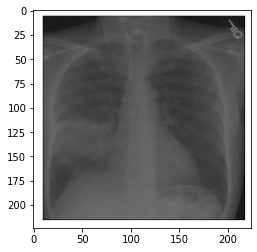

In [113]:
import matplotlib.pyplot as plt

plt.imshow(X[0])

In [114]:
# Storing the dataframes into CSV files for future access
images.to_csv('/home/gautam-admin/Desktop/anand nlp/project xray/Project/png_files_sample/images.csv', index=False)
data.to_csv('/home/gautam-admin/Desktop/anand nlp/project xray/Project/png_files_sample/train.csv', index=False)

# Importing train and image data

In [115]:
import pandas as pd
train = pd.read_csv('/home/gautam-admin/Desktop/anand nlp/project xray/Project/png_files_sample/train.csv')
train.head()

,Id,Genre,aaaalat,abd,ablation,abnormalites,abnormality,abnormality bronchovascular,abnormality coned,abnormality degenerative,...,worsening opacities,worsening pleural,worsening pna,worsening pneumothorax,worsening pulm,worsening pulmonary,worsening shortness,worsening sob,xarelto,xray
0,001fac99-3694d0bf-97264e61-ad66aacc-e369f694,['pleural effusion'],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0081e530-6eda3d1b-7bc3edec-353d9de5-125a8845,"['apical pneumothorax', 'cardiomediastinal', '...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0097ea99-f0ab02d7-87a960e8-53063e3b-d33b6de2,"['cardiopulmonary abnormality', 'cardiomediast...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00f0fe92-5e4d958c-4383973b-5799ed47-b882b7b3,"['pulmonary vasculature', 'pneumothorax gaseou...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0111d952-0df9e69b-c81b0fab-ba72f157-b5ace4b8,"['pneumothorax cardiomediastinal', 'pleural ef...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
images.head()

,Id,image
661,001fac99-3694d0bf-97264e61-ad66aacc-e369f694,"[[[1.0000000298023224, 1.0000000298023224, 1.0..."
1648,0081e530-6eda3d1b-7bc3edec-353d9de5-125a8845,"[[[1.0000000298023224, 1.0000000298023224, 1.0..."
320,0097ea99-f0ab02d7-87a960e8-53063e3b-d33b6de2,"[[[0.9999999999999991, 0.9999999999999991, 0.9..."
1442,00f0fe92-5e4d958c-4383973b-5799ed47-b882b7b3,"[[[1.0000000298023224, 1.0000000298023224, 1.0..."
1690,0111d952-0df9e69b-c81b0fab-ba72f157-b5ace4b8,"[[[0.9999999999999991, 0.9999999999999991, 0.9..."


In [117]:
print(X.shape)

(1722, 224, 224, 3)


In [118]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

In [119]:
y = np.array(train.drop(['Id', 'Genre'],axis=1))
y.shape

(1722, 1991)

In [120]:
train.columns

Index(['Id', 'Genre', 'aaaalat', 'abd', 'ablation', 'abnormalites',
       'abnormality', 'abnormality bronchovascular', 'abnormality coned',
       'abnormality degenerative',
       ...
       'worsening opacities', 'worsening pleural', 'worsening pna',
       'worsening pneumothorax', 'worsening pulm', 'worsening pulmonary',
       'worsening shortness', 'worsening sob', 'xarelto', 'xray'],
      dtype='object', length=1993)

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [122]:
model = Sequential()
model.add(Conv2D(filters=20, kernel_size=(5, 5), activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=100, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=500, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=1000, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(4000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1992, activation='sigmoid'))

In [123]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 220, 220, 20)      1520      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 20)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 110, 110, 20)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 106, 106, 100)     50100     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 53, 53, 100)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 53, 53, 100)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 49, 49, 500)      

In [124]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), batch_size=64)

Train on 1549 samples, validate on 173 samples
Epoch 1/1
1549/1549 [==============================] - 179s 116ms/step - loss: 0.0993 - accuracy: 0.9696 - val_loss: 0.0198 - val_accuracy: 0.9962


In [33]:
img = cv2.imread('/home/gautam-admin/Desktop/anand nlp/project xray/Project/png_files_sample/img/01e7cb2c-724a277f-c28ff848-25450474-62b930aa.png')
img = cv2.resize(img, (224,224))
img = img/255
img = np.array(img)

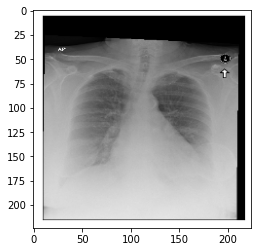

In [34]:
plt.imshow(img)

pneumothorax (0.632)
cardiopulmonary (0.348)
cardiomediastinal (0.323)


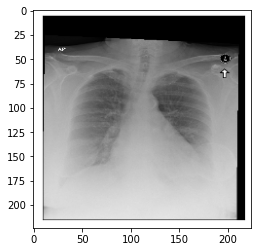

In [35]:
classes = np.array(train.columns[2:])
proba = model.predict(img.reshape(1,224,224,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)